# Projet - ITK/VTK - Etude longitudinale de l’évolution d’une tumeur

In [75]:
import numpy as np
import itk
import matplotlib.pyplot as plt
print(itk.Version.GetITKVersion())

5.3.0


In [76]:
# get the output image
PixelType = itk.F

images_1 = itk.imread("./Data/case6_gre1.nrrd", PixelType)
images_2 = itk.imread("./Data/case6_gre2.nrrd", PixelType)

images_1.shape, images_2.shape

((176, 256, 256), (176, 256, 256))

In [78]:
import itkwidgets
itkwidgets.view(images_2)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

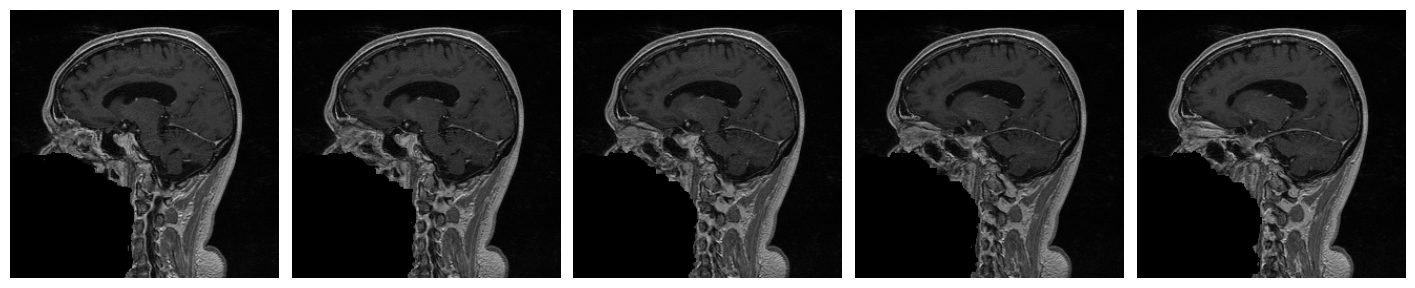

In [26]:
def print_5_slices(images, index_slice, dimension) :
    fig, axs = plt.subplots(1, 5, figsize=(18, 8))
    
    if dimension == 1 :
        if index_slice > images.shape[0] :
            raise ValueError("index_slice is higher than the number of slices")
        
        limit = index_slice
        i = 0
        while limit < images.shape[0] and i < 5 :
            limit += 1
            i += 1
        
        j = 0
        for i in range(index_slice, limit) :
            axs[j].imshow(images[i, :, :], cmap='gray')
            axs[j].axis('off')
            j += 1
    
    elif dimension >= 2 :
        if index_slice > images.shape[1] :
            raise ValueError("index_slice is higher than the number of slices")
        
        limit = index_slice
        i = 0
        while limit < images.shape[0] and i < 5 :
            limit += 1
            i += 1

        j = 0
        if dimension == 2 :
            for i in range(index_slice, limit) :
                axs[j].imshow(images[:, i, :], cmap='gray')
                axs[j].axis('off')
                j += 1
        else :
            for i in range(index_slice, limit) :
                axs[j].imshow(images[:, :, i], cmap='gray')
                axs[j].axis('off')
                j += 1
                
    plt.subplots_adjust(wspace=0.05)

print_5_slices(images_1, 100, 1)

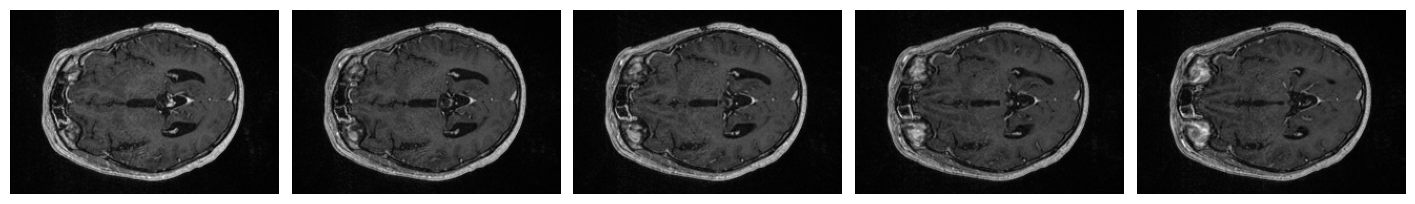

In [27]:
print_5_slices(images_1, 100, 2)

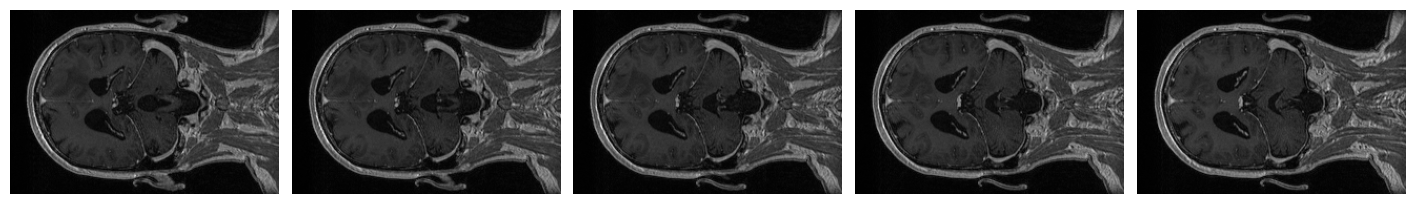

In [28]:
print_5_slices(images_1, 150, 3)

## Etape 1 - Recalage

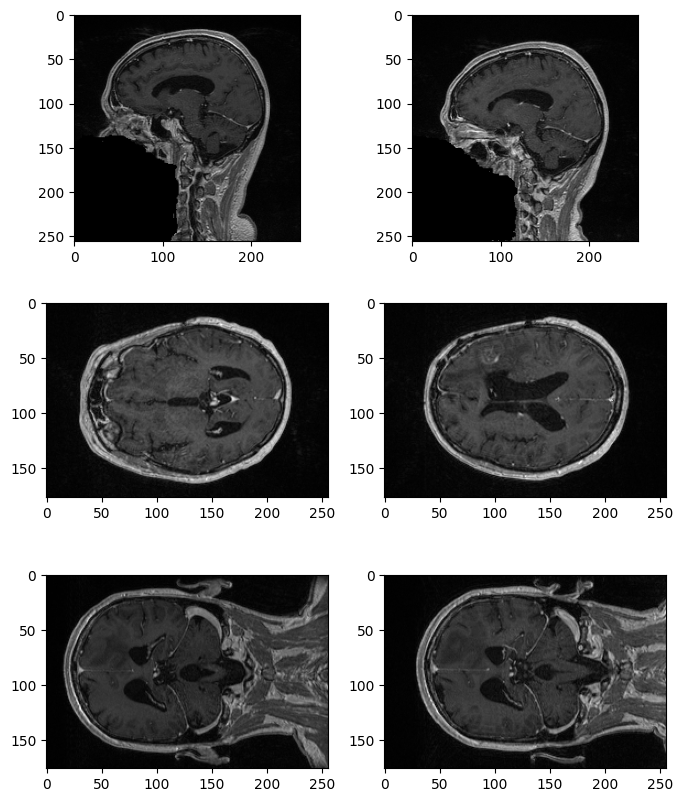

In [29]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes[0, 0].imshow(images_1[100, :, :], cmap='gray')
axes[0, 1].imshow(images_2[100, :, :], cmap='gray')
axes[1, 0].imshow(images_1[:, 100, :], cmap='gray')
axes[1, 1].imshow(images_2[:, 100, :], cmap='gray')
axes[2, 0].imshow(images_1[:, :, 150], cmap='gray')
axes[2, 1].imshow(images_2[:, :, 150], cmap='gray')

On peut remarquer qu'il y a une différence marquée d'aligement latéral entre les deux images. Nous effectuerons donc un recalage par translation pour aligner nos images.

In [30]:
dimension = 3
FixedImageType = type(images_1)
MovingImageType = type(images_2)

TransformType = itk.TranslationTransform[itk.D, dimension]
initialTransform = TransformType.New()

optimizer = itk.RegularStepGradientDescentOptimizerv4.New()

optimizer.SetLearningRate(1)
optimizer.SetMinimumStepLength(1e-6)
optimizer.SetNumberOfIterations(100)

metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()
fixed_interpolation = itk.LinearInterpolateImageFunction[FixedImageType, itk.D].New()
metric.SetFixedInterpolator(fixed_interpolation)

registration = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType].New(FixedImage=images_1, MovingImage=images_2, Metric=metric,
                                                                                    Optimizer=optimizer, InitialTransform=initialTransform)

moving_initial_transform = TransformType.New()
initial_parameters = moving_initial_transform.GetParameters()
initial_parameters[0] = 0
initial_parameters[1] = 0
moving_initial_transform.SetParameters(initial_parameters)
registration.SetMovingInitialTransform(moving_initial_transform)

identity_transform = TransformType.New()
identity_transform.SetIdentity()
registration.SetFixedInitialTransform(identity_transform)

registration.SetNumberOfLevels(1)

registration.Update()

transform = registration.GetTransform()
final_parameters = transform.GetParameters()
translation_along_x = final_parameters.GetElement(0)
translation_along_y = final_parameters.GetElement(1)
translation_along_z = final_parameters.GetElement(2)

number_of_iterations = optimizer.GetCurrentIteration()

best_value = optimizer.GetValue()

print("Result = ")
print(" Translation X = " + str(translation_along_x))
print(" Translation Y = " + str(translation_along_y))
print(" Translation Z = " + str(translation_along_z))
print(" Iterations    = " + str(number_of_iterations))
print(" Metric value  = " + str(best_value))

Result = 
 Translation X = -0.7927484241835651
 Translation Y = -3.5743807654084585
 Translation Z = -59.61025848317227
 Iterations    = 89
 Metric value  = 5614.108711314411


In [31]:
resampler = itk.ResampleImageFilter.New(Input=images_2, Transform=transform, UseReferenceImage=True,
                                        ReferenceImage=images_1)
resampler.SetDefaultPixelValue(0)

OutputImageType = itk.Image[PixelType, dimension]
images_2_resampled_casted = itk.CastImageFilter[FixedImageType, OutputImageType].New(resampler)

images_2_resampled = itk.array_from_image(images_2_resampled_casted)

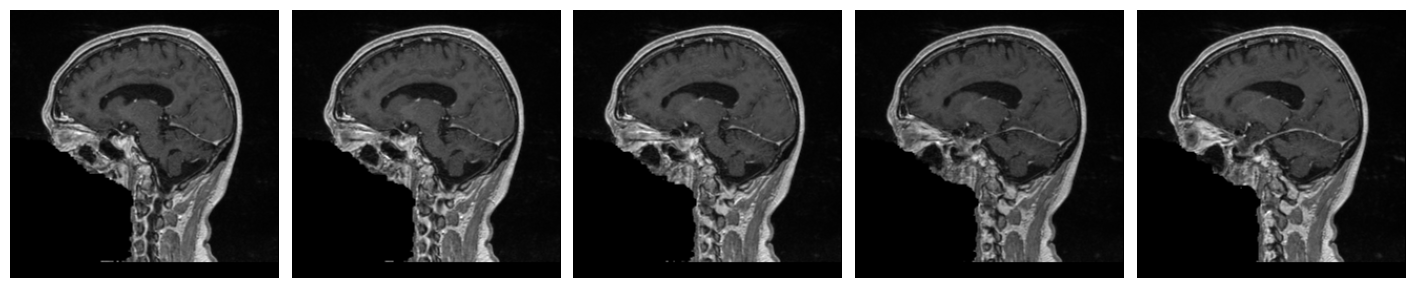

In [32]:
print_5_slices(images_2_resampled, 100, 1)

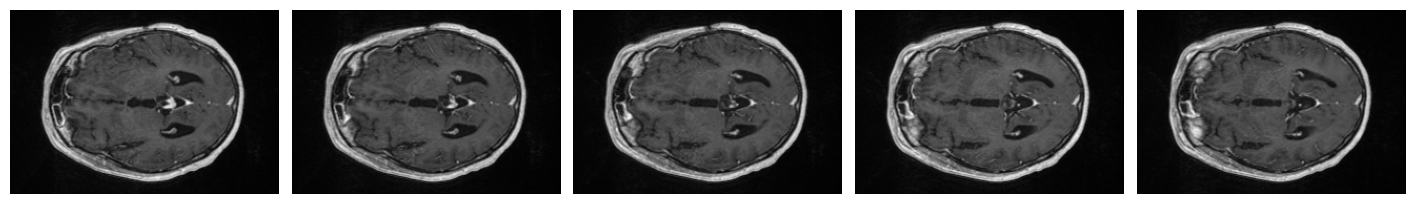

In [33]:
print_5_slices(images_2_resampled, 100, 2)

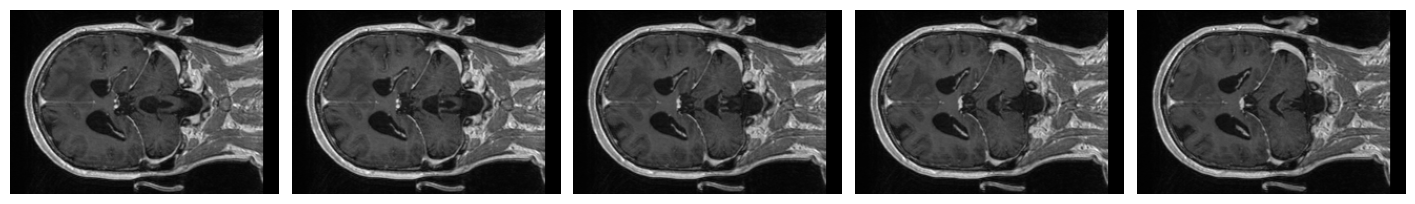

In [34]:
print_5_slices(images_2_resampled, 150, 3)

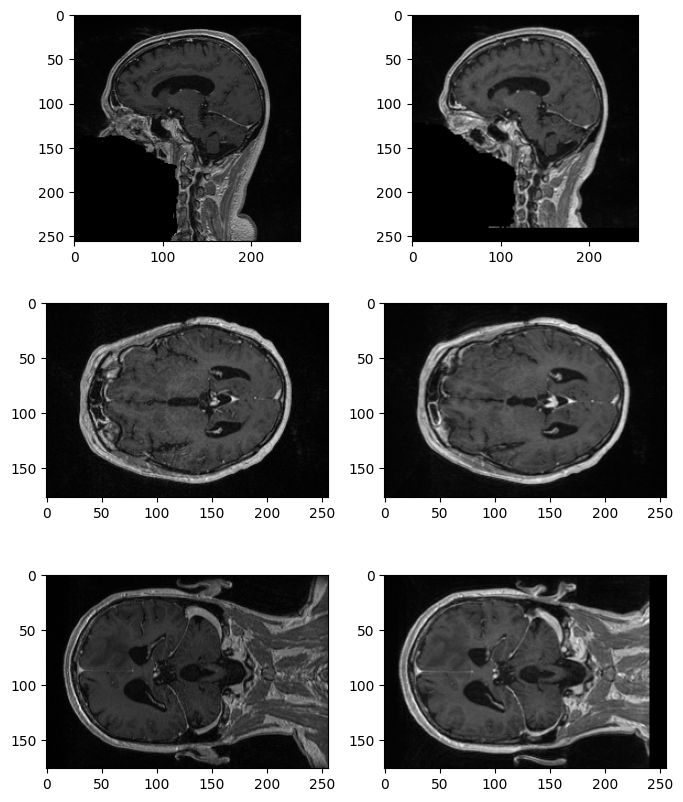

In [67]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))
axes[0, 0].imshow(images_1[100, :, :], cmap='gray')
axes[0, 1].imshow(images_2_resampled[100, :, :], cmap='gray')
axes[1, 0].imshow(images_1[:, 100, :], cmap='gray')
axes[1, 1].imshow(images_2_resampled[:, 100, :], cmap='gray')
axes[2, 0].imshow(images_1[:, :, 150], cmap='gray')
axes[2, 1].imshow(images_2_resampled[:, :, 150], cmap='gray')

In [70]:
import itkwidgets
itkwidgets.view(images_1)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [71]:
itkwidgets.view(images_2_resampled)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [116]:
pixel_value = images_2_resampled[44, 35, 47]
print(pixel_value)
print(type(images_2_resampled))


22.57154655456543
<class 'numpy.ndarray'>


## Etape 2 - Segmentation

## Preprocessing

In [118]:
images_2_resampled = images_2_resampled.astype(float)
images_2_resampled_itk = itk.image_from_array(images_2_resampled)


# Preprocess the images
smoothing = itk.CurvatureFlowImageFilter.New(Input=images_2_resampled_itk)
smoothing.SetNumberOfIterations(5)
smoothing.SetTimeStep(0.125)
smoothing.Update()

smoothed_image = smoothing.GetOutput()



<class 'itk.itkImagePython.itkImageD3'>
17.716520631578238


In [119]:
itkwidgets.view(smoothed_image)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

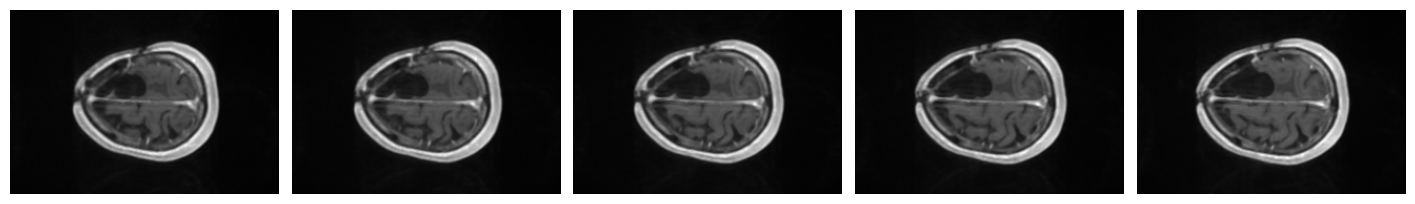

In [120]:
print_5_slices(smoothed_image, 40, 2)

In [181]:
# Perform region growing
ConnectedFilterType = itk.ConnectedThresholdImageFilter[itk.Image[itk.D,3], itk.Image[itk.D,3]]
connectedThreshold = ConnectedFilterType.New()


lower_threshold = 50.
upper_threshold = 100.

connectedThreshold.SetInput(smoothed_image)
connectedThreshold.SetLower(lower_threshold)
connectedThreshold.SetUpper(upper_threshold)
connectedThreshold.SetReplaceValue(255)

In [182]:
# Set seed point
index = (100,64,68)
connectedThreshold.SetSeed(index)
seed_value = smoothed_image.GetPixel((100,64,68))
print("Seed value:", seed_value)
try:
    connectedThreshold.Update()
except Exception as e:
    print(f"Exception caught! {e}")

# The resulting segmented image is then:
segmented_image = connectedThreshold.GetOutput()

Seed value: 66.78759959196499


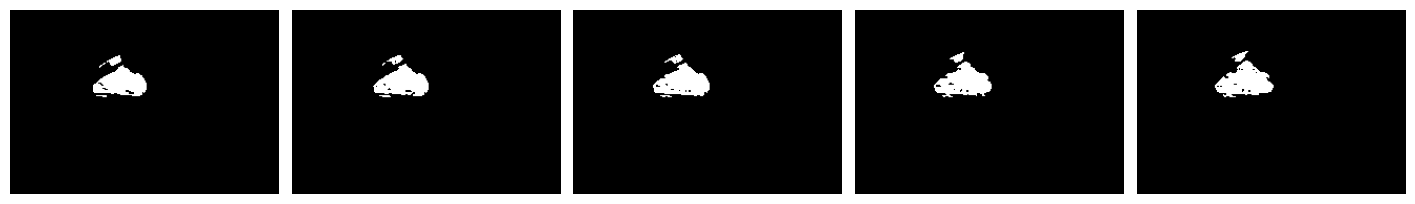

In [184]:
print_5_slices(segmented_image, 45, 2)

In [185]:
itkwidgets.view(segmented_image)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…